In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Load libraries

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import confusion_matrix

import tensorflow as tf
tf.random.set_seed(0)
tf.keras.backend.clear_session

<function tensorflow.python.keras.backend.clear_session()>

# Load data

In [3]:
path = '/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/'
tdat = pd.read_csv(path+'icml_face_data.csv')
tdat.sample(5)

,emotion,Usage,pixels
21608,2,Training,185 186 188 188 182 167 164 181 187 205 202 19...
29918,2,PublicTest,153 166 191 185 175 123 137 126 184 194 177 16...
29334,3,PublicTest,47 57 75 71 83 97 98 79 68 77 85 89 100 106 11...
21534,3,Training,100 94 77 76 78 85 71 78 71 49 60 80 62 51 62 ...
4891,2,Training,181 184 184 176 166 164 161 154 153 155 153 15...


In [4]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Preprocess data

In [5]:
tdat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [6]:
dat = tdat.copy()
dat.drop_duplicates(inplace=True)
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34653 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  34653 non-null  int64 
 1    Usage   34653 non-null  object
 2    pixels  34653 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [7]:
dat[' Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

[Text(0, 0, 'Angry'),
 Text(1, 0, 'Disgust'),
 Text(2, 0, 'Fear'),
 Text(3, 0, 'Happy'),
 Text(4, 0, 'Sad'),
 Text(5, 0, 'Surprise'),
 Text(6, 0, 'Neutral')]

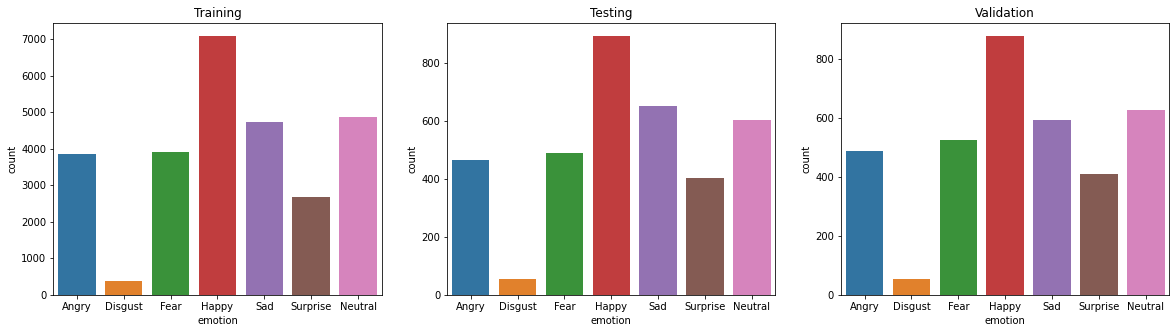

In [8]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
sns.countplot(data = dat[dat[' Usage']=='Training'], x='emotion', ax=ax1).set_title('Training')
ax1.set_xticklabels(emotions.values())
sns.countplot(data = dat[dat[' Usage']=='PublicTest'], x='emotion', ax=ax2).set_title('Testing')
ax2.set_xticklabels(emotions.values())
sns.countplot(data = dat[dat[' Usage']=='PrivateTest'], x='emotion', ax=ax3).set_title('Validation')
ax3.set_xticklabels(emotions.values())

# Helper functions

In [9]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

  
def sample_plot(x,y=None):
    #x, y are numpy arrays
    n = 20
    samples = random.sample(range(x.shape[0]),n)
    
    fig, axs = plt.subplots(2,10, figsize=(25,5), sharex=True, sharey=True)
    ax = axs.ravel()
    for i in range(n):
        ax[i].imshow(x[samples[i],:,:], cmap=plt.get_cmap('gray'))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        if y is not None:
            ax[i].set_title(emotions[y[samples[i]]])
              

# Prepare data for CNN, accounting for class imbalance

In [48]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline

from collections import Counter

In [11]:
train_image_array1, train_image_label1 = prepare_data(dat[dat[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(dat[dat[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(dat[dat[' Usage']=='PublicTest'])

In [54]:
# pp = Pipeline([('rus',RandomUnderSampler(random_state=0, replacement=False))])
pp = Pipeline([('tk',TomekLinks()),('ros',RandomOverSampler(random_state=0))])
train_image_array, train_image_label = pp.fit_resample(train_image_array1.reshape(train_image_array1.shape[0],48*48), train_image_label1)
print(Counter(train_image_label))
train_image_array = train_image_array.reshape(train_image_array.shape[0], 48, 48)

Counter({0: 6885, 4: 6885, 6: 6885, 2: 6885, 3: 6885, 5: 6885, 1: 6885})


In [55]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')

train_labels = tf.keras.utils.to_categorical(train_image_label)
val_labels = tf.keras.utils.to_categorical(val_image_label)
test_labels = tf.keras.utils.to_categorical(test_image_label)

# Sample and visualize images from train/valid/test data sets

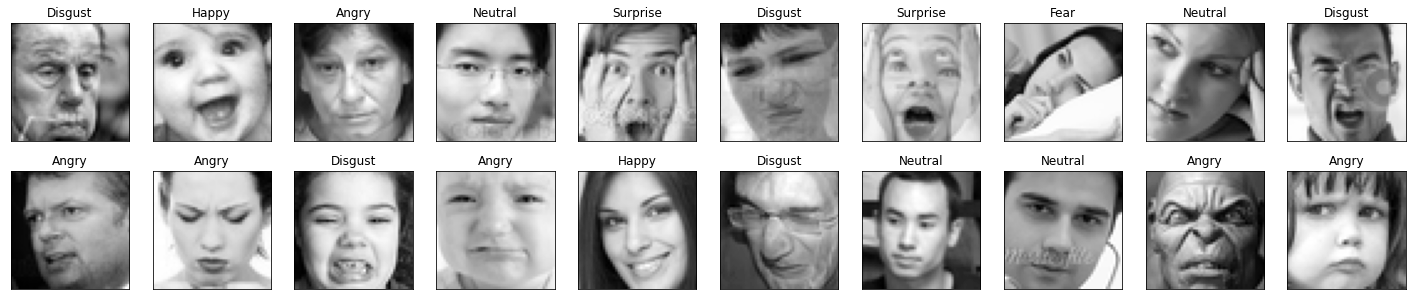

In [14]:
sample_plot(train_image_array, train_image_label)

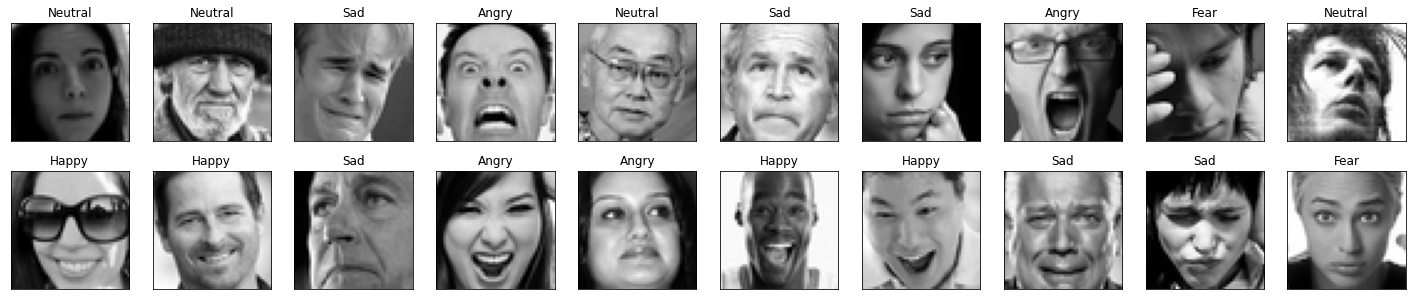

In [15]:
sample_plot(val_image_array, val_image_label)

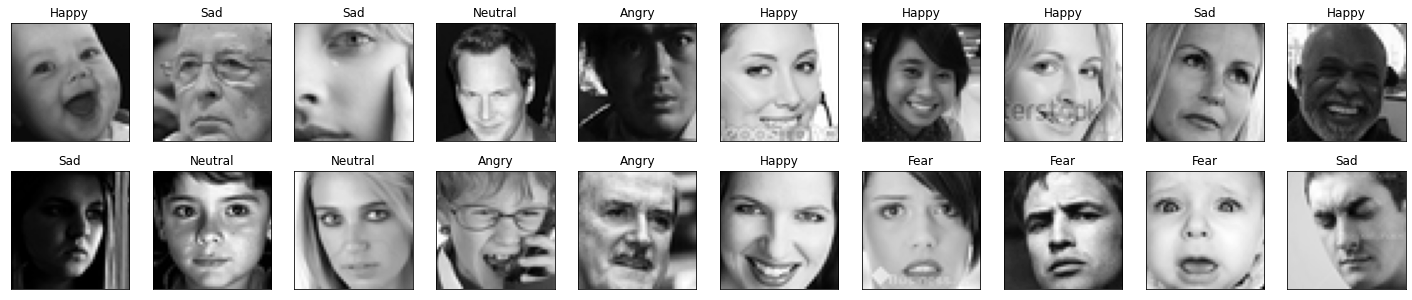

In [16]:
sample_plot(test_image_array, test_image_label)

In [56]:
wt = dat[dat[' Usage']=="Training"].groupby('emotion').agg('count')
# class_weights = 
wt['fraction'] = wt[' pixels']/np.sum(wt[' pixels'])
class_weights = dict(zip(range(7), wt.fraction))

# CNN

In [57]:
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(48,48,1)),
    tf.keras.layers.experimental.preprocessing.RandomContrast(factor = 0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
    
    tf.keras.layers.Conv2D(16,3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(16,5,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(16,3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2),
    
    tf.keras.layers.Conv2D(16,3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(16,3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(emotions), activation='softmax'),    
])

In [58]:
from sklearn.metrics import f1_score

def eager_f1score(y_true, y_pred):
    return f1_score(y_true=np.argmax(np.array(y_true), axis=1), y_pred=np.argmax(np.array(y_pred),axis=1), average='macro')


# eager_f1score(test_image_label, test_pred)

In [59]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', 
              metrics=['accuracy',eager_f1score], run_eagerly=True)

earlystop = tf.keras.callbacks.EarlyStopping(patience=10, min_delta=1e-4, restore_best_weights=True)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-7)

In [60]:
hist = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=50,
#                     class_weight=class_weights,
                    batch_size=128,
                    callbacks=[earlystop, lr])

Epoch 1/50
377/377 [==============================] - 23s 62ms/step - loss: 1.8815 - accuracy: 0.2804 - eager_f1score: 0.2635 - val_loss: 2.0158 - val_accuracy: 0.2040 - val_eager_f1score: 0.1705
Epoch 2/50
377/377 [==============================] - 23s 62ms/step - loss: 1.3686 - accuracy: 0.4738 - eager_f1score: 0.4554 - val_loss: 1.3987 - val_accuracy: 0.4659 - val_eager_f1score: 0.4159
Epoch 3/50
377/377 [==============================] - 23s 61ms/step - loss: 1.1436 - accuracy: 0.5635 - eager_f1score: 0.5473 - val_loss: 1.3643 - val_accuracy: 0.4821 - val_eager_f1score: 0.4348
Epoch 4/50
377/377 [==============================] - 24s 62ms/step - loss: 1.0223 - accuracy: 0.6138 - eager_f1score: 0.6005 - val_loss: 1.3098 - val_accuracy: 0.5090 - val_eager_f1score: 0.4573
Epoch 5/50
377/377 [==============================] - 24s 63ms/step - loss: 0.9374 - accuracy: 0.6472 - eager_f1score: 0.6373 - val_loss: 1.2894 - val_accuracy: 0.5224 - val_eager_f1score: 0.4912
Epoch 6/50
377/377 [

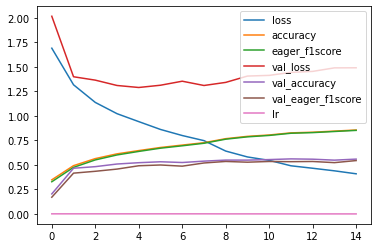

In [61]:
for key in hist.history.keys():
    plt.plot(hist.history[key], label=key)
plt.legend()

In [62]:
model.evaluate(test_images, test_labels)
test_pred = model.predict(test_images)
confusion_matrix(y_true=test_image_label, y_pred=np.argmax(test_pred,axis=1))

112/112 [==============================] - 4s 39ms/step - loss: 1.3290 - accuracy: 0.5224 - eager_f1score: 0.4719


array([[166,   8,  57,  46,  87,  14,  86],
       [  4,  32,   4,   5,   8,   0,   2],
       [ 48,   3, 154,  44, 100,  58,  84],
       [ 41,   2,  38, 636,  65,  23,  89],
       [ 66,   8,  94,  66, 253,  17, 148],
       [ 21,   0,  41,  20,  13, 287,  21],
       [ 30,   0,  59,  63, 110,   9, 334]])